# **Respiratory Sound Classification** 
## Based on BiGRU-Attention Network with XGBoost


### Importing Packages

In [1]:
%pip install pyACA

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pyACA
import sklearn
from sklearn import preprocessing
from sklearn import model_selection
from sklearn.model_selection import train_test_split as tts
from sklearn import metrics
from sklearn.utils import shuffle
from xgboost import XGBClassifier as XGB
import librosa
import librosa.display
import IPython.display as ipd
from tqdm import tqdm


import tensorflow as tf
import keras
from keras.layers import *
from keras.models import *
from keras import backend as K
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Dropout, Embedding, LSTM, Bidirectional
import keras.layers as Layers

import warnings
warnings.filterwarnings("ignore")

## 1. **Feature Extraction**
We will be using following features for the classification purpose :
* Short-term Average Zero-crossing Rate
* Spectral Centroid
* Spectral Slope
* Spectral Contrast
* RMS Energy
* Chromaticity
* MFCC

In [3]:
raw_dataset = './raw dataset/'
csv_path = './mldata.csv'
np_dir = './np_arrays/'
final_dataset = './final_dataset/'

f_start = 101
f_end = 639

labels_df = pd.read_csv(csv_path)

In [4]:
FRAME_LENGTH = 1024
HOP_LENGTH = 512

def SpectralSlope(data, sr, hop_length):
    ss = []
    for i in range(0,len(data),512):
        slice = data[i:i+512]
        s = pyACA.FeatureSpectralSlope(slice, f_s=sr)
        ss.append(s*512)
    return np.array(ss)

def grad(arr):
    arr = np.array(arr)
    grad_arr = []
    for i in range(arr.shape[0]):
        grad_arr.append(np.gradient(arr[i]))
    return np.array(grad_arr)

def extract_features(file_path: str, frame_length, hop_length):

    audio_signal, sr = librosa.load(file_path)

    stft = np.abs(librosa.stft(audio_signal))
    mfccs_features = librosa.feature.mfcc(audio_signal, sr=sr, n_mfcc=12)
    # mfccs_scaled_features = np.mean(mfccs_features.T, axis=0)
    mfccs_grad = grad(mfccs_features)
    all_mfccs = np.concatenate((mfccs_features,mfccs_grad))
    # chroma = np.mean(librosa.feature.chroma_stft(S=stft, sr=sr).T, axis=0)
    chroma = librosa.feature.chroma_stft(S=stft, sr=sr)
    # contrast = np.mean(librosa.feature.spectral_contrast(S=stft, sr=sr).T, axis=0)
    contrast = librosa.feature.spectral_contrast(S=stft, sr=sr)
    zcr = frame_length*(librosa.feature.zero_crossing_rate(audio_signal, frame_length=frame_length, hop_length=hop_length)[0])
    rms = librosa.feature.rms(audio_signal, frame_length=frame_length, hop_length=hop_length)[0]
    spectral_centroid = librosa.feature.spectral_centroid(audio_signal, sr=sr, n_fft=frame_length, hop_length=hop_length)[0]
    spectral_slope = SpectralSlope(audio_signal, sr, hop_length)

    return [zcr, rms, spectral_centroid, all_mfccs, chroma, contrast, spectral_slope]


Note : 3 cells below are not to be run again as the dataset is already stored in .npz files

In [5]:
# for patient in tqdm(range(f_start,f_end+1), 'Extraction Progress '):
#   file_name = os.path.join(os.path.abspath(raw_dataset)+'/'+str(patient)+'.wav')
#   extracted_arrs = extract_features(file_name,FRAME_LENGTH,HOP_LENGTH)
#   np.savez(np_dir+str(patient)+'.npz',zcr = extracted_arrs[0],rms = extracted_arrs[1],spectral_centroid = extracted_arrs[2],\
#            mfcc = extracted_arrs[3], chroma = extracted_arrs[4],spectral_contrast = extracted_arrs[5], spectral_slope=extracted_arrs[6])

### Creating Final Dataset
> Note : To be run only once

In [6]:
# data_3d = []

# for patient in range(f_start,f_end+1):
#     arrs = np.load(np_dir+str(patient)+'.npz')
#     final = []
#     for i in arrs:
#         f_arr = None
#         if patient==f_start:
#             print(i,arrs[i].shape)
#         if arrs[i].shape[0]<100:
#             for ar in arrs[i]:
#                 f_arr = ar
#                 if f_arr.shape[0]<862:
#                     new_f = np.zeros(862)
#                     for ii in range(f_arr.shape[0]):
#                         new_f[ii] = f_arr[ii]
#                     final.append(new_f)
#                 else:
#                     final.append(f_arr[:862])
#         else:
#             f_arr = arrs[i]
#             if f_arr.shape[0]<862:
#                 new_f = np.zeros(862)
#                 for ii in range(f_arr.shape[0]):
#                     new_f[ii] = f_arr[ii]
#                 final.append(new_f)
#             else:
#                 final.append(f_arr[:862])
    
#     final = np.array(final).T
#     np.save(final_dataset+str(patient)+'.npy',final)
#     data_3d.append(final)

# data_3d = np.array(data_3d)
# df = {'features':data_3d}

zcr (862,)\
rms (862,)\
spectral_centroid (862,)\
mfcc (24, 862)\
chroma (12, 862)\
spectral_contrast (7, 862)\
spectral_slope (862,)

In [7]:
# print(data_3d.shape)

(539, 862, 47)

In [8]:
labels = []

for i in range(len(labels_df)):
    crackles = labels_df['crackles'][i]
    wheezes = labels_df['wheezes'][i]
    if crackles==0 and wheezes==0:
        labels.append(0)
    elif crackles and wheezes:
        labels.append(3)
    elif crackles==0 and wheezes!=0:
        labels.append(2)
    elif crackles!=0 and wheezes==0:
        labels.append(1)
    else:
        labels.append(-1)

labels_df['class'] = labels
labels_df = pd.concat([labels_df['patient'], labels_df['crackles'],labels_df['wheezes'],labels_df['class']], axis=1)
labels_df.to_csv(csv_path)

labels_df.head(10)

,patient,crackles,wheezes,class
0,101,0,11,2
1,102,0,0,0
2,103,0,5,2
3,104,0,2,2
4,105,0,0,0
5,106,0,0,0
6,107,5,0,1
7,108,8,1,3
8,109,10,0,1
9,110,13,0,1


In [9]:
data_3d = []                                                                    # ran ~ 3 min 30 secs

for patient in range(f_start,f_end+1):
    row = np.load(final_dataset+str(patient)+'.npy')
    data_3d.append(row)

df = pd.DataFrame({'patient':labels_df['patient'], 'features':data_3d, 'class':labels_df['class']})
df.head()

,patient,features,class
0,101,"[[0.0, 0.0, 0.0, -445.4117126464844, 0.0, 0.0,...",2
1,102,"[[0.0, 0.09875842928886414, 1049.1760661583844...",0
2,103,"[[6.0, 0.06401204317808151, 659.8168860261126,...",2
3,104,"[[0.0, 0.0844806358218193, 1117.7693469286253,...",2
4,105,"[[0.0, 0.0, 0.0, -424.2092590332031, 0.0, 0.0,...",0


In [184]:
X = np.asarray(data_3d)
Y = np.asarray(labels_df['class'])

X_train, X_test, Y_train, Y_test = tts(X,Y, test_size=0.3, random_state=42)
X_train, X_val, Y_train, Y_val = tts(X_train,Y_train, test_size=0.25, random_state=42)


X_train = np.asarray(X_train)
X_test = np.asarray(X)
Y_test = np.asarray(Y)
X_val = np.asarray(X_val)

In [185]:
OneHot = sklearn.preprocessing.OneHotEncoder()

OneHot.fit(np.reshape(Y_train, (-1,1)))

Y_train_OH = OneHot.transform(np.reshape(Y_train, (-1,1))).toarray()
Y_val_OH = OneHot.transform(np.reshape(Y_val, (-1,1))).toarray()
Y_test_OH = OneHot.transform(np.reshape(Y_test, (-1,1))).toarray()
Y_OH = OneHot.transform(np.reshape(Y, (-1,1))).toarray()

Y_train_OH

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       ...,
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]])

## **Bi-LSTM Models**

### Model 1 : Bi-LSTM Model

In [12]:
import pydotplus                        # for plotting models
pydotplus.find_graphviz()

{'dot': 'C:\\Program Files (x86)\\Graphviz\\bin\\dot.exe',
 'twopi': 'C:\\Program Files (x86)\\Graphviz\\bin\\twopi.exe',
 'neato': 'C:\\Program Files (x86)\\Graphviz\\bin\\neato.exe',
 'circo': 'C:\\Program Files (x86)\\Graphviz\\bin\\circo.exe',
 'fdp': 'C:\\Program Files (x86)\\Graphviz\\bin\\fdp.exe',
 'sfdp': 'C:\\Program Files (x86)\\Graphviz\\bin\\sfdp.exe'}

Model: "model_86"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_88 (InputLayer)       [(None, 862, 47)]         0         
                                                                 
 bidirectional_87 (Bidirecti  (None, 862, 256)         180224    
 onal)                                                           
                                                                 
 flatten_87 (Flatten)        (None, 220672)            0         
                                                                 
 dense_258 (Dense)           (None, 1024)              225969152 
                                                                 
 dense_259 (Dense)           (None, 256)               262400    
                                                                 
 dense_260 (Dense)           (None, 4)                 1028      
                                                          

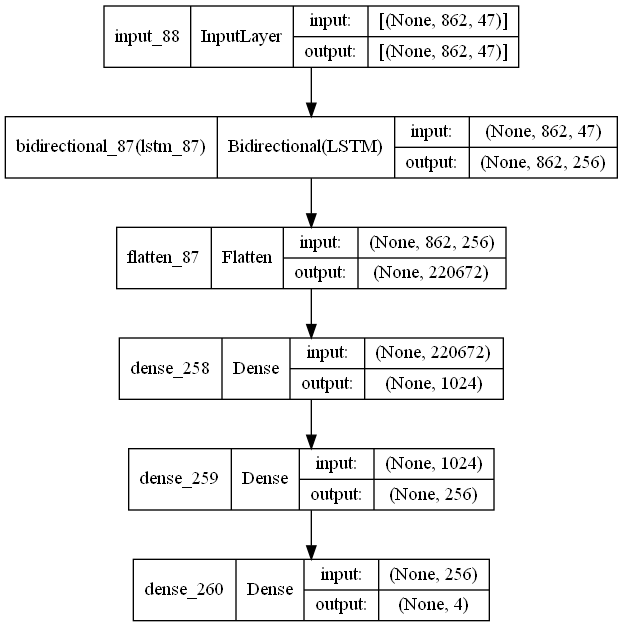

In [210]:
input1 = tf.keras.Input(shape=(862,47))
x1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,input_shape=(None,862,47),return_sequences=True, dropout=0.01,recurrent_dropout=0.01))(input1)
x2 = tf.keras.layers.Flatten()(x1)
x3 = tf.keras.layers.Dense(1024, activation="relu")(x2)
x5 = tf.keras.layers.Dense(256, activation="relu")(x3)
output1 = tf.keras.layers.Dense(4, activation="sigmoid")(x5)
model1 =keras.Model(inputs=input1, outputs=[output1])

model1.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0005), metrics=['accuracy'])
model1.summary()

tf.keras.utils.plot_model(model1, "./model_imgs/model1.png",show_shapes=True)

### Model 2 : Bi-LSTM + Attention Layer

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 862, 47)]    0           []                               
                                                                                                  
 bidirectional_4 (Bidirectional  (None, 862, 16)     3584        ['input_5[0][0]']                
 )                                                                                                
                                                                                                  
 flatten_4 (Flatten)            (None, 13792)        0           ['bidirectional_4[0][0]']        
                                                                                                  
 dense_12 (Dense)               (None, 512)          7062016     ['flatten_4[0][0]']        

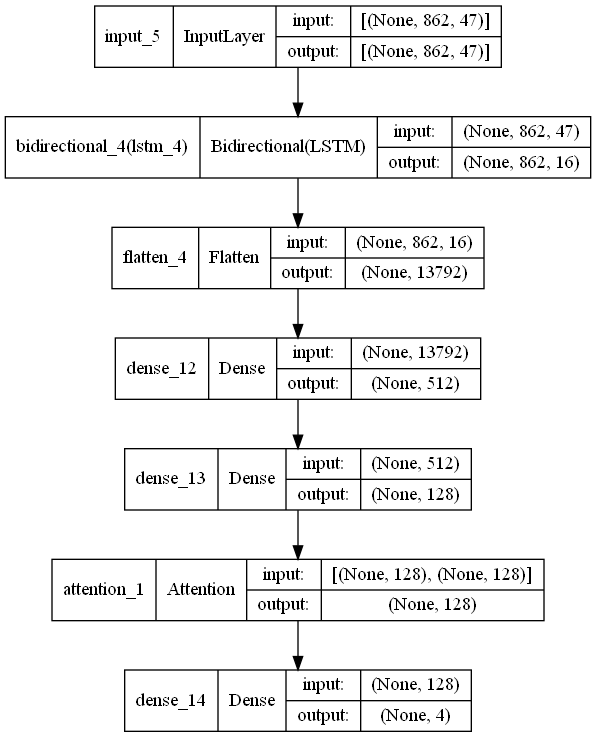

In [19]:
class attention(Layer):
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(attention,self).__init__()

    def build(self, input_shape):
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="normal")
        super(attention,self).build(input_shape)

    def call(self, x):
        e = K.tanh(K.dot(x,self.W)+self.b)
        a = K.softmax(e, axis=1)
        output = x*a
        if self.return_sequences:
            return output
        return K.sum(output, axis=1)


input2 = tf.keras.Input(shape=(862,47))
xx1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(8,input_shape=(None,862,47),return_sequences=True, dropout=0.2,recurrent_dropout=0.1))(input2)
xx2 = tf.keras.layers.Flatten()(xx1)
xx2 = tf.keras.layers.Dense(512, activation="relu")(xx2)
xx3 = tf.keras.layers.Dense(128, activation="relu")(xx2)
# xx4 = attention(return_sequences=True)(xx3)
xx4 = tf.keras.layers.Attention()([xx3,xx3])
out2=tf.keras.layers.Dense(4, activation="sigmoid")(xx4)

model2 =keras.Model(inputs=input2, outputs=out2)

model2.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0005), metrics=['accuracy'])
model2.summary()

tf.keras.utils.plot_model(model2, "./model_imgs/model2.png",show_shapes=True)

### Model 3 : Bi-LSTM + XGBoost

In [214]:
class BiLSTM_plus_XGB():

    def __init__(self, n_epochs=10, n_LSTMS=16, dense1=512, dense2=256, n_classes=4, loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0001)):
        self.n_LSTMS = n_LSTMS
        self.dense1 = dense1
        self.dense2 = dense2
        self.loss = loss
        self.optimizer = optimizer
        self.n_classes = n_classes
        self.n_epochs = n_epochs


    def fit(self, X_train, Y_train, xgb_model):
        self.xgb_model = xgb_model
        self.X_train = X_train
        self.Y_train = Y_train

        self.OneHot = sklearn.preprocessing.OneHotEncoder()
        self.OneHot.fit(np.reshape(Y_train, (-1,1)))
        self.Y_train_OH = self.OneHot.transform(np.reshape(Y_train, (-1,1))).toarray()

        self._make_biLSTM()

        zz1 = self.model.get_layer(index=1)(self.X_train)
        zz2 = self.model.get_layer(index=2)(zz1)
        train_features_xgb = self.model.get_layer(index=3)(zz2)

        self.xgb_model.fit(np.array(train_features_xgb), self.Y_train)

    
    def _make_biLSTM(self):

        input3 = tf.keras.Input(shape=(862,47))
        z1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(self.n_LSTMS,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.03))(input3)
        z2 = tf.keras.layers.Flatten()(z1)
        z3 = tf.keras.layers.Dense(self.dense1, activation="relu")(z2)
        z5 = tf.keras.layers.Dense(self.dense2, activation="relu")(z3)
        z6 = tf.keras.layers.Attention()([z5,z5])
        output3 = tf.keras.layers.Dense(self.n_classes, activation="softmax")(z6)
        model3 =keras.Model(inputs=[input3], outputs=[output3])

        model3.compile(loss=self.loss, optimizer=self.optimizer, metrics=['accuracy'])
        model3.summary()
        self.model = model3

        tf.keras.utils.plot_model(model3, "./model_imgs/model3.png",show_shapes=True)
        
        self.model.fit(x=self.X_train, y=self.Y_train_OH,
                            batch_size = 32,
                            epochs = self.n_epochs,
                            verbose = 2,
                            validation_split = 0.2)

        self.model = model3


    def predict(self, X_test):
        self.X_test = X_test
        zz1 = self.model.get_layer(index=1)(self.X_test)
        zz2 = self.model.get_layer(index=2)(zz1)
        test_features_xgb = self.model.get_layer(index=3)(zz2)
        self.final_preds = self.xgb_model.predict(test_features_xgb)

        return self.final_preds

In [218]:
model3 = BiLSTM_plus_XGB(n_epochs=10, n_LSTMS=64, optimizer=tf.keras.optimizers.SGD(0.002))
model3.fit(X_train, Y_train, xgb_model = XGB())
xgb_preds = model3.predict(X)

Model: "model_89"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_91 (InputLayer)          [(None, 862, 47)]    0           []                               
                                                                                                  
 bidirectional_90 (Bidirectiona  (None, 862, 128)    57344       ['input_91[0][0]']               
 l)                                                                                               
                                                                                                  
 flatten_90 (Flatten)           (None, 110336)       0           ['bidirectional_90[0][0]']       
                                                                                                  
 dense_267 (Dense)              (None, 1024)         112985088   ['flatten_90[0][0]']      

In [219]:
print(metrics.accuracy_score(Y, xgb_preds))

0.6975881261595547


In [198]:
input3 = tf.keras.Input(shape=(862,47))
z1 = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,input_shape=(None,862,47),return_sequences=True, dropout=0.05,recurrent_dropout=0.03))(input3)
z2 = tf.keras.layers.Flatten()(z1)
z3 = tf.keras.layers.Dense(1024, activation="relu")(z2)
z5 = tf.keras.layers.Dense(256, activation="relu")(z3)
output3 = tf.keras.layers.Dense(4, activation="softmax")(z5)
model3 =keras.Model(inputs=[input3], outputs=[output3])

model3.compile(loss='CategoricalCrossentropy', optimizer=tf.keras.optimizers.SGD(0.0001), metrics=['accuracy'])
model3.summary()

tf.keras.utils.plot_model(model3, "./model_imgs/model3.png",show_shapes=True)

print(X_train.shape, Y_train_OH.shape)
history = model3.fit(X_train, Y_train_OH,
                    batch_size = 32,
                    epochs = 1,
                    verbose = 2,
                    validation_split = 0.2)

loss, accuracy = model1.evaluate(X, Y_OH, batch_size = 32, verbose=2)
print(f'\n\ntest accuracy : ',accuracy)


zz1 = model3.get_layer(index=1)(X_train)
zz2 = model3.get_layer(index=2)(zz1)
zz3 = model3.get_layer(index=3)(zz2)

print('zz3 : ',zz3.shape)

intermediate_layer_model = keras.Model(inputs=model3.input,outputs=model3.get_layer(index=3).output)
features_xgb = intermediate_layer_model(X_train)

xgb_model = XGB()
xgb_model.fit(features_xgb, Y_train)

zz1 = model3.get_layer(index=1)(X_test)
zz2 = model3.get_layer(index=2)(zz1)
zz3 = model3.get_layer(index=3)(zz2)

print('zz3 : ',zz3.shape)

intermediate_layer_model = keras.Model(inputs=model3.input,outputs=model3.get_layer(index=3).output)
features_test = intermediate_layer_model(X)
ypreds = xgb_model.predict(features_test)

print(metrics.accuracy_score(Y, ypreds))

Model: "model_80"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_84 (InputLayer)       [(None, 862, 47)]         0         
                                                                 
 bidirectional_83 (Bidirecti  (None, 862, 128)         57344     
 onal)                                                           
                                                                 
 flatten_83 (Flatten)        (None, 110336)            0         
                                                                 
 dense_246 (Dense)           (None, 1024)              112985088 
                                                                 
 dense_247 (Dense)           (None, 256)               262400    
                                                                 
 dense_248 (Dense)           (None, 4)                 1028      
                                                          

### Training Models

Epoch 1/15

Epoch 00001: val_accuracy improved from -inf to 0.28070, saving model to .\weights.h5
8/8 - 168s - loss: 1.4018 - accuracy: 0.3156 - val_loss: 1.6313 - val_accuracy: 0.2807 - 168s/epoch - 21s/step
Epoch 2/15

Epoch 00002: val_accuracy did not improve from 0.28070
8/8 - 140s - loss: 1.3818 - accuracy: 0.3067 - val_loss: 1.5042 - val_accuracy: 0.2632 - 140s/epoch - 18s/step
Epoch 3/15

Epoch 00003: val_accuracy did not improve from 0.28070
8/8 - 133s - loss: 1.2962 - accuracy: 0.3733 - val_loss: 1.3974 - val_accuracy: 0.2807 - 133s/epoch - 17s/step
Epoch 4/15

Epoch 00004: val_accuracy improved from 0.28070 to 0.31579, saving model to .\weights.h5
8/8 - 147s - loss: 1.2517 - accuracy: 0.4089 - val_loss: 1.4955 - val_accuracy: 0.3158 - 147s/epoch - 18s/step
Epoch 5/15

Epoch 00005: val_accuracy improved from 0.31579 to 0.36842, saving model to .\weights.h5
8/8 - 143s - loss: 1.2534 - accuracy: 0.4000 - val_loss: 1.4387 - val_accuracy: 0.3684 - 143s/epoch - 18s/step
Epoch 6/15


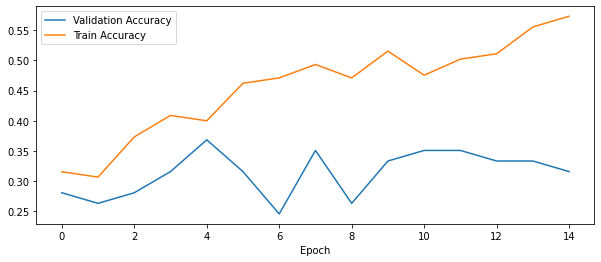

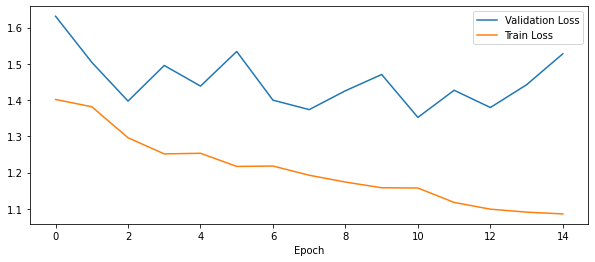

In [211]:
checkpoint = tf.keras.callbacks.ModelCheckpoint('./weights.h5', monitor='val_accuracy', save_best_only=True, verbose=2)

history = model1.fit(X_train, Y_train_OH,
                    batch_size = 32,
                    epochs = 15,
                    verbose = 2,
                    validation_split = 0.2,callbacks=[checkpoint])

loss, accuracy = model1.evaluate(X, Y_OH, batch_size = 32, verbose=2)

print('\n\nTest loss:', loss)
print('Test accuracy:', accuracy)

dff = pd.DataFrame(history.history)
plt.figure(figsize=(10,4))
plt.plot(range(len(dff['val_accuracy'])), dff['val_accuracy'], label='Validation Accuracy')
plt.plot(range(len(dff['accuracy'])), dff['accuracy'], label='Train Accuracy')
plt.legend()
plt.xlabel('Epoch')
plt.show()

plt.figure(figsize=(10,4))
plt.plot(range(len(dff['val_loss'])), dff['val_loss'], label='Validation Loss')
plt.plot(range(len(dff['loss'])), dff['loss'], label='Train Loss')
plt.legend()
plt.xlabel('Epoch')
plt.show()